## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
"""
from keras.callbacks import EarlyStopping
_patience = [10,25]

results = {}
for p in _patience:
    earlystop = EarlyStopping(monitor="val_loss", 
                          patience=p, 
                          verbose=1
                          )
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = "exp-l2-%s" % str(p)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0730 09:52:40.492653 11072 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 09:53:08.864396 11072 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 09:53:13.805879 11072 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 09:53:17.188939 11072 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0730 09:53:17.778491 11072 deprecation_wrapper.py

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

W0730 09:53:18.211333 11072 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 83s 2ms/step - loss: 2.1980 - acc: 0.2735 - val_loss: 2.0599 - val_acc: 0.3291
Epoch 2/50
50000/50000 [==============================] - 11s 228us/step - loss: 1.7397 - acc: 0.3967 - val_loss: 1.7886 - val_acc: 0.3913
Epoch 3/50
50000/50000 [==============================] - 11s 222us/step - loss: 1.6169 - acc: 0.4356 - val_loss: 1.6960 - val_acc: 0.4080
Epoch 4/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.5432 - acc: 0.4603 - val_loss: 1.6320 - val_acc: 0.4271
Epoch 5/50
50000/50000 [==============================] - 11s 226us/step - loss: 1.4903 - acc: 0.4788 - val_loss: 1.5919 - val_acc: 0.4411
Epoch 6/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.4439 - acc: 0.4968 - val_loss: 1.5712 - val_acc: 0.4510
Epoch 7/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.4049 - acc: 0.5112 - val_loss: 1.5400

Epoch 27/50
50000/50000 [==============================] - 10s 196us/step - loss: 0.9247 - acc: 0.6890 - val_loss: 1.4681 - val_acc: 0.4985
Epoch 28/50
50000/50000 [==============================] - 9s 178us/step - loss: 0.9059 - acc: 0.6984 - val_loss: 1.4789 - val_acc: 0.4957
Epoch 29/50
50000/50000 [==============================] - 8s 157us/step - loss: 0.8860 - acc: 0.7049 - val_loss: 1.4808 - val_acc: 0.4967
Epoch 30/50
50000/50000 [==============================] - 9s 190us/step - loss: 0.8659 - acc: 0.7141 - val_loss: 1.4756 - val_acc: 0.5011
Epoch 31/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.8471 - acc: 0.7189 - val_loss: 1.4904 - val_acc: 0.4964
Epoch 32/50
50000/50000 [==============================] - 9s 189us/step - loss: 0.8271 - acc: 0.7271 - val_loss: 1.4983 - val_acc: 0.4972
Epoch 33/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.8088 - acc: 0.7363 - val_loss: 1.4970 - val_acc: 0.5021
Epoch 34/50
50000/50000 

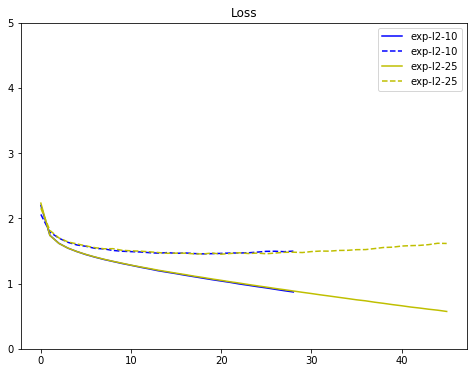

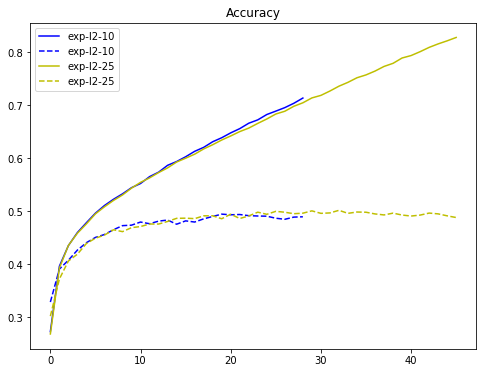

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["b", "y"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()